In [7]:
import numpy as np
import os
import pyreadr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import torch
# import lightgbm as lgb
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# import tensorflow as tf

sns.set()


In [2]:
train_normal_path = './Dataset/TEP_FaultFree_Training.RData'
train_faulty_path = './Dataset/TEP_Faulty_Training.RData'

test_normal_path = './Dataset/TEP_FaultFree_Testing.RData'
test_faulty_path = './Dataset/TEP_Faulty_Testing.RData'


train_df = pyreadr.read_r(train_normal_path)['fault_free_training']    # (250000, 55)
test_df = pyreadr.read_r(test_faulty_path)['faulty_testing']


In [4]:
train_df.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


In [5]:
train_df.faultNumber.value_counts()

0.0    250000
Name: faultNumber, dtype: int64

In [6]:
test_df.head()
test_df.faultNumber.value_counts()



1     480000
2     480000
3     480000
4     480000
5     480000
6     480000
7     480000
8     480000
9     480000
10    480000
11    480000
12    480000
13    480000
14    480000
15    480000
16    480000
17    480000
18    480000
19    480000
20    480000
Name: faultNumber, dtype: int64

In [8]:
def qqplot_by_fault(data_df, cols, fault_number):
    plt.figure(figsize=(14,14))
    
    for i in range(len(cols)):
        ax = plt.subplot(4, 4, i+1)
        data = data_df[(data_df.faultNumber==fault_number) & (data_df.simulationRun.isin(range(10)))][cols[i]]
        
        #data = np.log(data)
        
        stats.probplot(x=data, plot=plt)
        ax.set_title(cols[i])
        ax.set_xlabel('')
        ax.set_ylabel('')
        shapiro = stats.shapiro(data)
        ax.text(0.99, 0.01, '{0:.4f}'.format(shapiro[1]),
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='green', fontsize=15)
        
    plt.show()

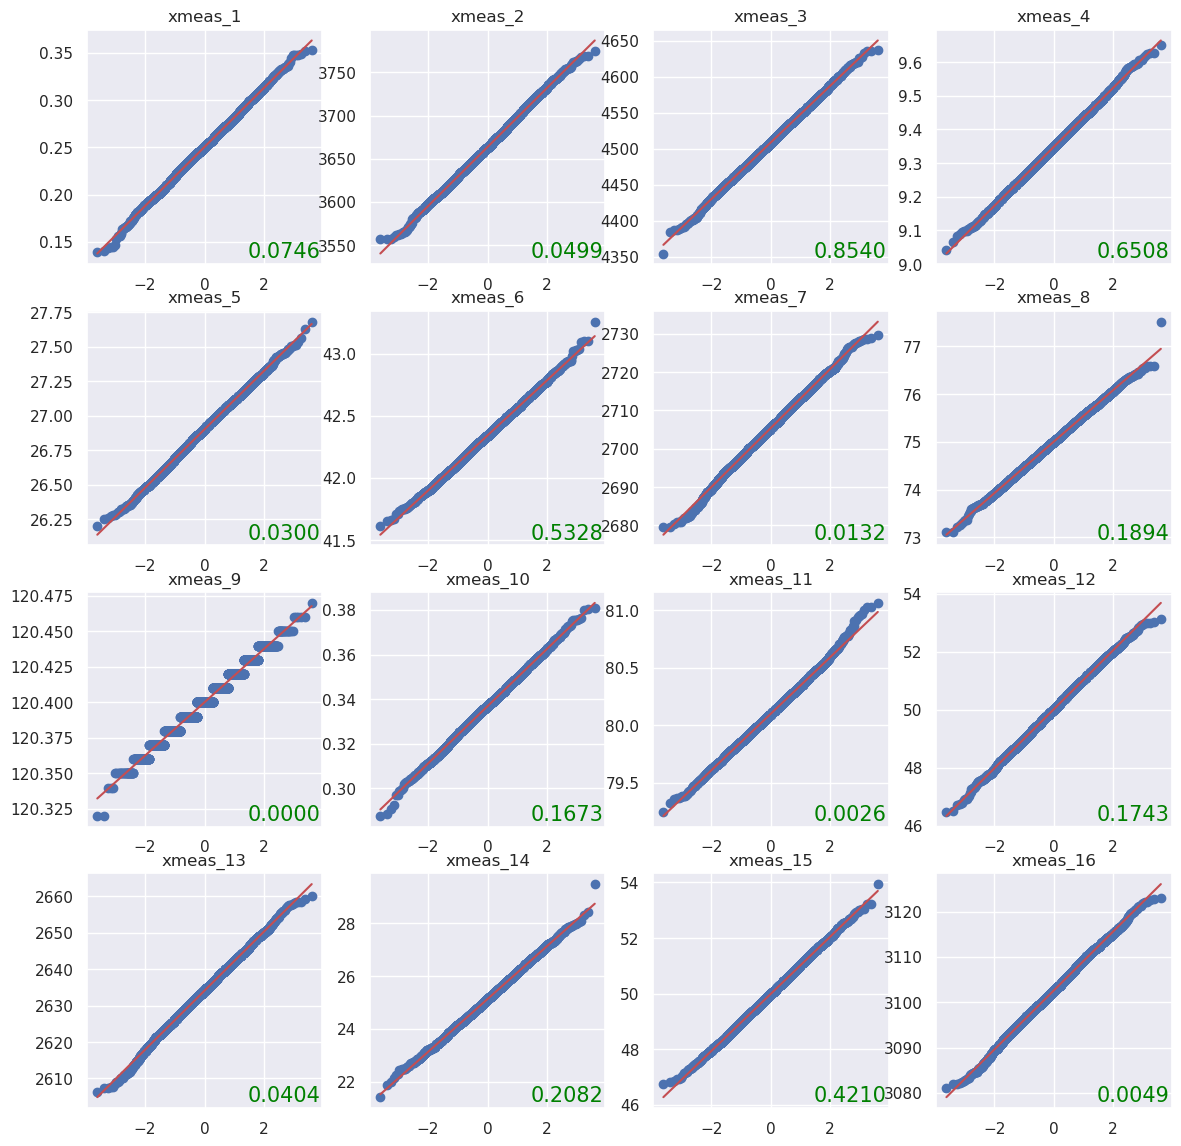

In [9]:
qqplot_by_fault(train_df, train_df.columns[3:19], fault_number=0)

In [16]:
train_df[(train_df.faultNumber==0) & (train_df.simulationRun.isin(range(10)))][train_df.columns[:3]]

,faultNumber,simulationRun,sample
0,0.0,1.0,1
1,0.0,1.0,2
2,0.0,1.0,3
3,0.0,1.0,4
4,0.0,1.0,5
...,...,...,...
4495,0.0,9.0,496
4496,0.0,9.0,497
4497,0.0,9.0,498
4498,0.0,9.0,499


In [17]:
alpha = 0.05

def get_shapiro(data_df, cols, fault_number):
    shapiro_history = []
    for i in range(len(cols)):
        data = data_df[(data_df.faultNumber==fault_number) & (data_df.simulationRun.isin(range(9)))][cols[i]]
        #data = np.log(data)
        shapiro = stats.shapiro(data)
        shapiro_history.append(shapiro)
    return shapiro_history

def plot_shapiro(shapiro_history):
    W,p = zip(*shapiro_history)
    plt.plot(p)
    plt.axhline(y=alpha, color='r', linestyle='-')
    plt.title('p_value >= {0} for {1} features'.format(alpha, len([i for i in p if i >= alpha])))
    plt.xlabel('feature')
    plt.ylabel('p_value')
    plt.show()

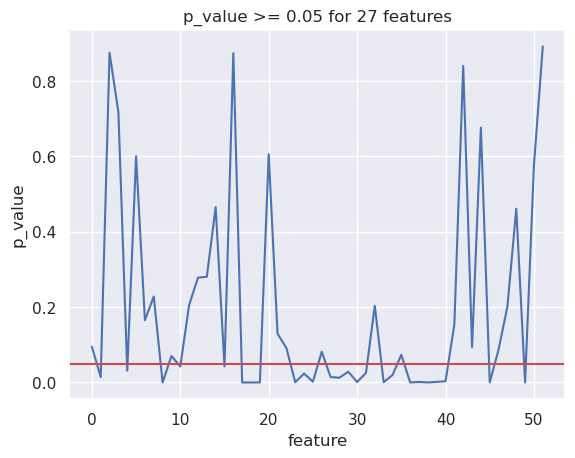

[ True False  True  True False  True  True  True False  True False  True
  True  True  True False  True False False False  True  True  True False
 False False  True False False False False False  True False False  True
 False False False False False  True  True  True  True False  True  True
  True False  True  True]


In [22]:
faultless_shapiro = get_shapiro(train_df, train_df.columns[3:55], fault_number=0)
plot_shapiro(faultless_shapiro)

w,p_values = zip(*faultless_shapiro)
faultless_cond = pd.DataFrame(index=train_df.columns[3:55],columns=['isNormal']).fillna(False)
i=0
for p in p_values:
    if p >= 0.05:
        faultless_cond.iloc[i] = True
    i+=1
# print(f'{faultless_cond.isNormal.values}')

In [21]:
all_shap = []
for fault in range(1,21):
    shap = get_shapiro(test_df, test_df.columns[3:55], fault_number=fault)
    all_shap.append(shap)
# all_shap

/home/sihoon/anaconda3/envs/HAVOK_test/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


[[ShapiroResult(statistic=0.7613624930381775, pvalue=0.0),
  ShapiroResult(statistic=0.9994639754295349, pvalue=0.02279352769255638),
  ShapiroResult(statistic=0.9669567346572876, pvalue=1.1435105541531522e-38),
  ShapiroResult(statistic=0.9506579637527466, pvalue=5.605193857299268e-45),
  ShapiroResult(statistic=0.9996963143348694, pvalue=0.3123385012149811),
  ShapiroResult(statistic=0.999569296836853, pvalue=0.07811489701271057),
  ShapiroResult(statistic=0.8212823271751404, pvalue=0.0),
  ShapiroResult(statistic=0.9694399237632751, pvalue=1.6737447411604596e-37),
  ShapiroResult(statistic=0.9780784845352173, pvalue=9.376345383013362e-33),
  ShapiroResult(statistic=0.9849956631660461, pvalue=9.548208885342848e-28),
  ShapiroResult(statistic=0.8504416942596436, pvalue=0.0),
  ShapiroResult(statistic=0.9997273683547974, pvalue=0.419737309217453),
  ShapiroResult(statistic=0.8393542766571045, pvalue=0.0),
  ShapiroResult(statistic=0.9997746348381042, pvalue=0.619294285774231),
  Shapir

In [24]:
fault_numbers = []
skewed_features = pd.DataFrame(index=train_df.columns[3:55],columns=['frequency']).fillna(0)

for i in range(20):
    w,p_values = zip(*all_shap[i])
    p_count = len([a for a in p_values if a >= 0.05])
    #print("%d -> %d" % (i + 1, p_count))
    if (p_count < 20):
        fault_numbers.append(i+1)
        
    feature_number = 0
    for p in p_values:
        if p < 0.05:
            # 귀무가설이 틀렸다= normal distribution이 아니다 | 모든 fault 경우에 대해 몇 번 발생했는지 카운팅
            skewed_features.iloc[feature_number] += 1   
        feature_number+=1

#print("------------")
#print(len(fault_numbers))
# skewed_features

,frequency
xmeas_1,10
xmeas_2,7
xmeas_3,10
xmeas_4,9
xmeas_5,4
xmeas_6,9
xmeas_7,20
xmeas_8,16
xmeas_9,20
xmeas_10,16


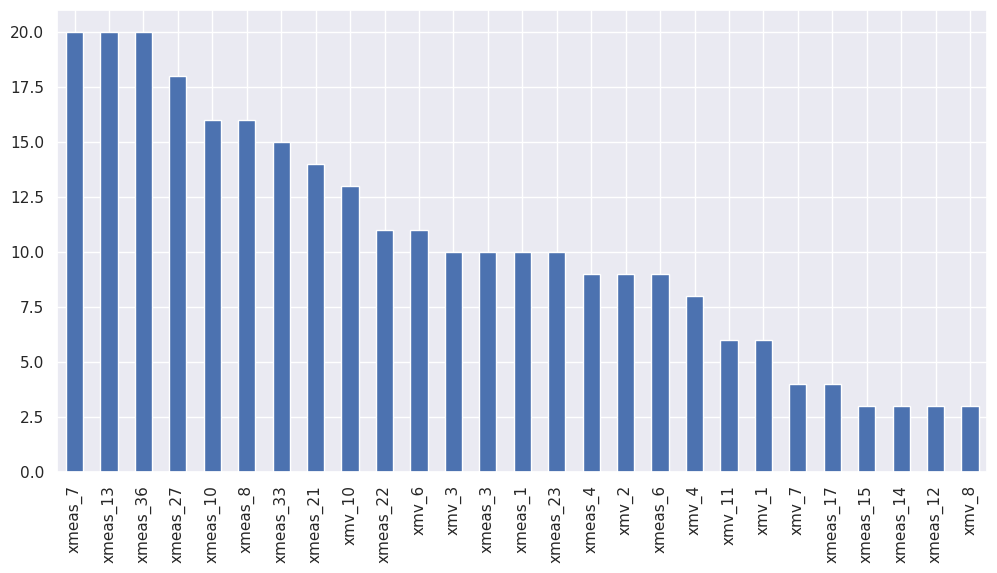

In [25]:
plt.figure(figsize=(12,6))

skewed_features[faultless_cond.isNormal.values].frequency.sort_values(ascending=False).plot(kind='bar');

In [26]:
n_prob_features=10

feature_cols = skewed_features[faultless_cond.isNormal].frequency.sort_values(ascending=False).head(n_prob_features).index.values
print(feature_cols)

['xmeas_7' 'xmeas_13' 'xmeas_36' 'xmeas_27' 'xmeas_10' 'xmeas_8'
 'xmeas_33' 'xmeas_21' 'xmv_10' 'xmeas_22']


In [30]:
scaler = preprocessing.MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(X = train_df[(train_df.faultNumber == 0) & (train_df.simulationRun.isin(range(400)))].loc[:,feature_cols]))

means = data.mean()
variances = data.std()

model_prob = pd.DataFrame(index = feature_cols, data = {'mean': means.values, 'variance': variances.values})
model_prob.head(n_prob_features)


,mean,variance
xmeas_7,0.490172,0.113015
xmeas_13,0.493977,0.111739
xmeas_36,0.500548,0.120703
xmeas_27,0.522407,0.122750
xmeas_10,0.473183,0.114341
xmeas_8,0.483362,0.111506
xmeas_33,0.477033,0.114613
xmeas_21,0.490483,0.110456
xmv_10,0.471319,0.101071
xmeas_22,0.505249,0.113515


In [31]:
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

def get_probability(x, model):
    res = gaussian(x.values, model['mean'].values, model['variance'].values)
    return res.prod()

def alert_condition(x):
    return np.max(x)

def metric_prob(probs, window_minutes, eps):    
    #samples are sampled each 3 minutes
    window_points = window_minutes // 3
    rolled = probs.rolling(window=window_points).apply(alert_condition, raw=True)    
    ind = np.where(rolled < eps)
    
    if len(ind[0])>0:
        return ind[0][0]

    return 0

            0         1         2         3         4         5         6  \
0    0.491018  0.483003  0.501244  0.522594  0.483124  0.438643  0.477576   
1    0.476048  0.477337  0.501244  0.522594  0.488415  0.405550  0.477576   
2    0.495509  0.504249  0.532911  0.605021  0.471356  0.577184  0.426224   
3    0.505988  0.512748  0.532911  0.605021  0.486316  0.570401  0.426224   
4    0.505988  0.512748  0.547387  0.564017  0.632184  0.515108  0.479630   
..        ...       ...       ...       ...       ...       ...       ...   
495  0.511976  0.514164  0.570459  0.536820  0.559478  0.262487  0.460459   
496  0.498503  0.495751  0.664782  0.609623  0.315088  0.376773  0.516946   
497  0.495509  0.490085  0.664782  0.609623  0.343733  0.631655  0.516946   
498  0.522455  0.515581  0.563673  0.840586  0.404306  0.568140  0.440603   
499  0.519461  0.515581  0.563673  0.840586  0.437603  0.527235  0.440603   

            7         8         9  
0    0.490328  0.479042  0.485428  
1  

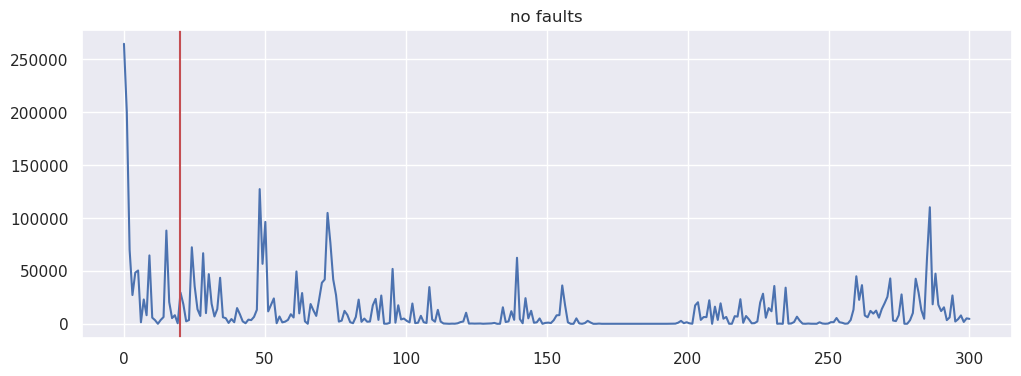

0      210621.012633
1      135241.258089
2       25778.186091
3       22193.244387
4       23046.504129
           ...      
955         4.198153
956         3.418987
957         6.991239
958      2164.708901
959       247.841815
Length: 960, dtype: float64


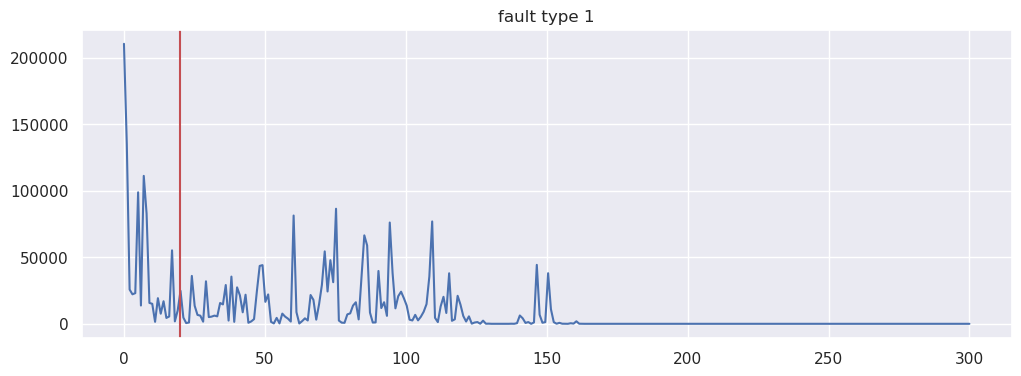

0       1.743124e+04
1       6.668679e+03
2       1.396048e+05
3       3.553084e+04
4       2.345829e+04
           ...      
955    1.065612e-187
956    7.838111e-188
957    4.556385e-187
958    3.828417e-186
959    1.348017e-188
Length: 960, dtype: float64


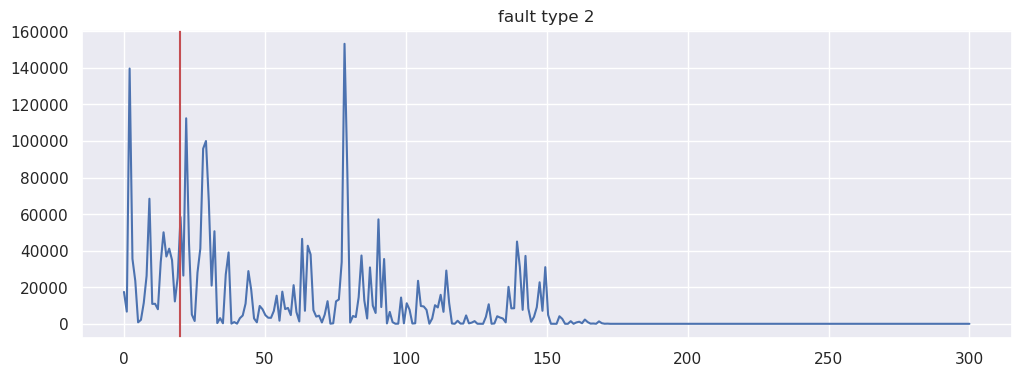

0      140618.625702
1      115459.803419
2       21035.890373
3       10562.233925
4       28777.499062
           ...      
955      6908.555193
956      2992.824135
957      8328.440171
958      6279.767597
959     90701.402766
Length: 960, dtype: float64


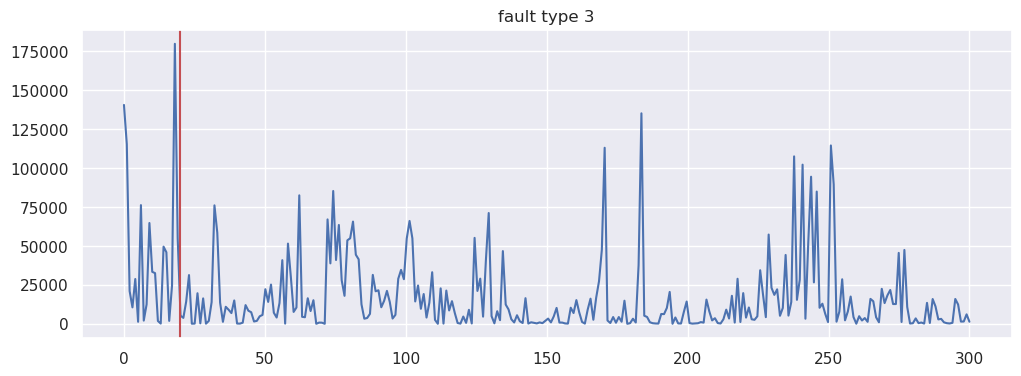

0      2.464825e+05
1      7.918752e+04
2      1.199190e+05
3      1.070306e+05
4      4.216639e+04
           ...     
955    1.840715e-11
956    6.672000e-13
957    1.423204e-05
958    1.426025e-14
959    4.838114e-14
Length: 960, dtype: float64


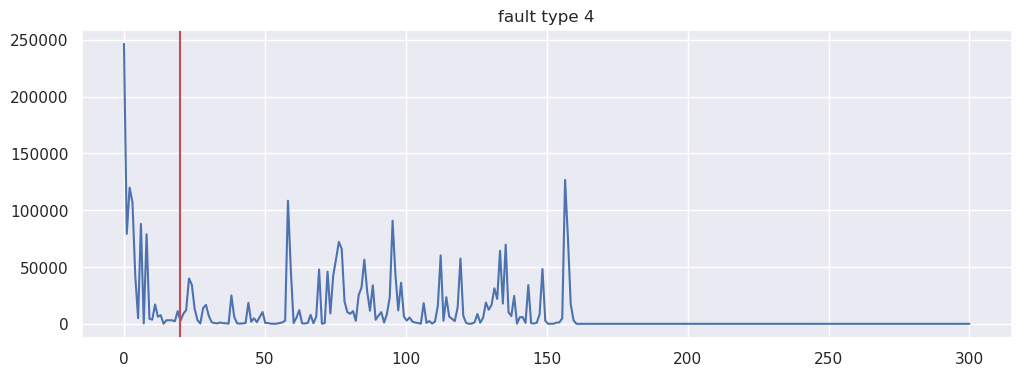

0       83406.007567
1      112993.691723
2       55820.374459
3      110028.339055
4       20817.854169
           ...      
955      3171.308031
956      2489.156722
957     37170.029780
958      2204.184308
959       156.510772
Length: 960, dtype: float64


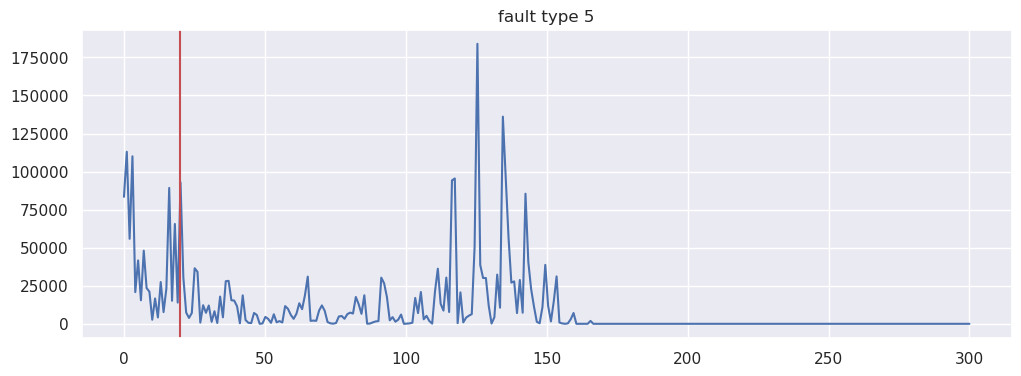

0      171253.811814
1      122169.260584
2        7365.495723
3        1368.230990
4         141.680869
           ...      
955         0.000000
956         0.000000
957         0.000000
958         0.000000
959         0.000000
Length: 960, dtype: float64


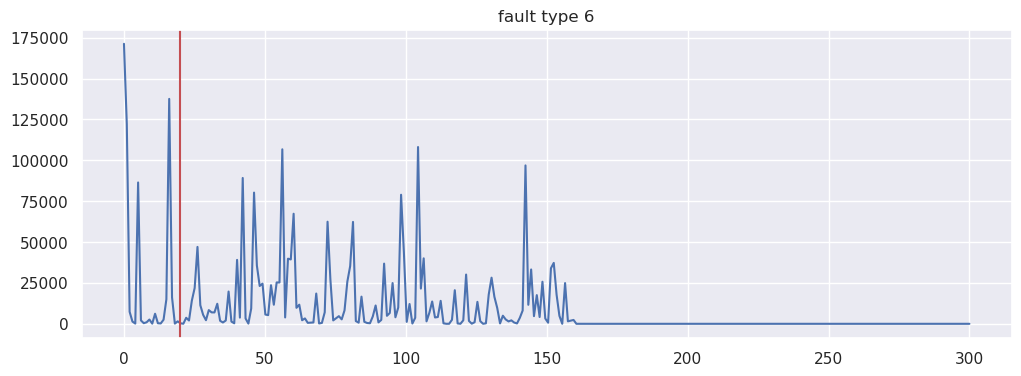

0       79083.077900
1      233673.384246
2       93770.156022
3      143311.053085
4       29721.102362
           ...      
955       667.911208
956       883.615816
957      9360.204347
958      8878.116619
959        86.943154
Length: 960, dtype: float64


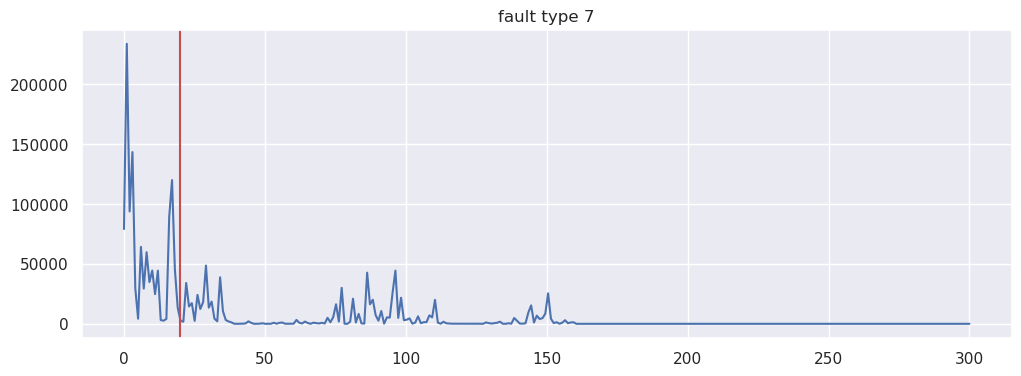

0      1.215651e+05
1      8.895595e+04
2      3.985375e+04
3      3.403890e+04
4      2.072938e+05
           ...     
955    3.378848e-19
956    8.782812e-20
957    3.377565e-20
958    9.177918e-27
959    2.272767e-24
Length: 960, dtype: float64


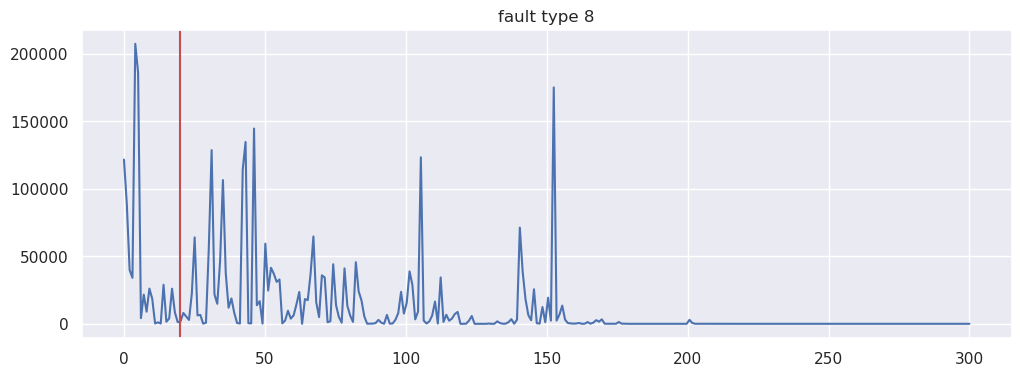

0      108575.617091
1       83330.404510
2       60602.738838
3       23869.029776
4       55685.057114
           ...      
955    104179.871359
956    153584.483457
957    147836.017759
958      4752.257191
959      8971.281088
Length: 960, dtype: float64


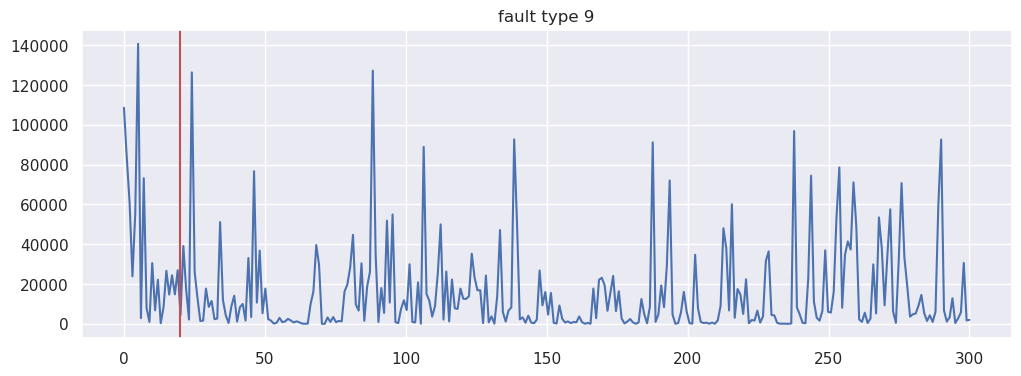

0      216492.979082
1      205192.666327
2       87802.303435
3       41245.628633
4        2306.168968
           ...      
955         5.534835
956      2388.588717
957       971.405882
958         4.239280
959         9.184910
Length: 960, dtype: float64


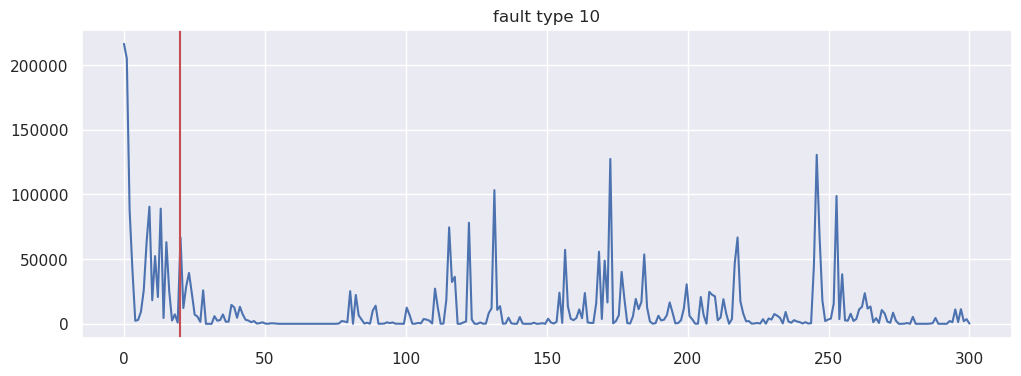

0      186010.920425
1       51646.120038
2       41583.531074
3       24524.497854
4        2867.432602
           ...      
955         0.000626
956       518.346110
957       259.969619
958         0.002552
959         0.000688
Length: 960, dtype: float64


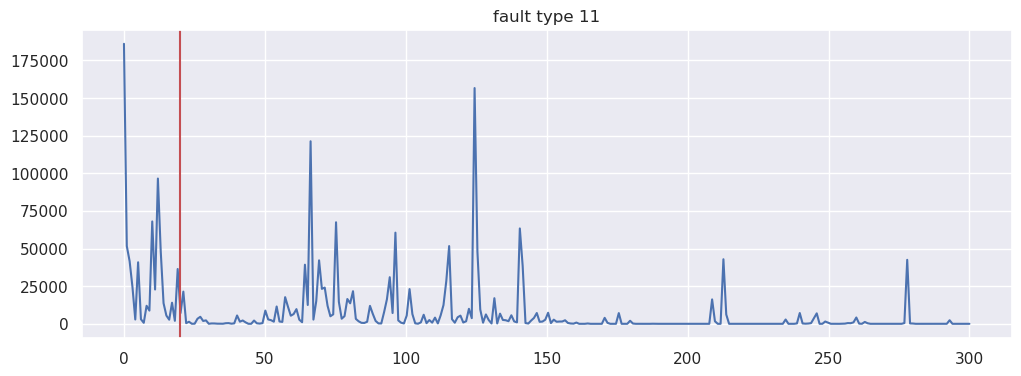

0      1.101253e+05
1      1.088759e+05
2      5.059402e+04
3      4.562467e+04
4      4.172809e+04
           ...     
955    4.619616e-25
956    2.332275e-31
957    7.544944e-50
958    9.262497e-63
959    2.486394e-36
Length: 960, dtype: float64


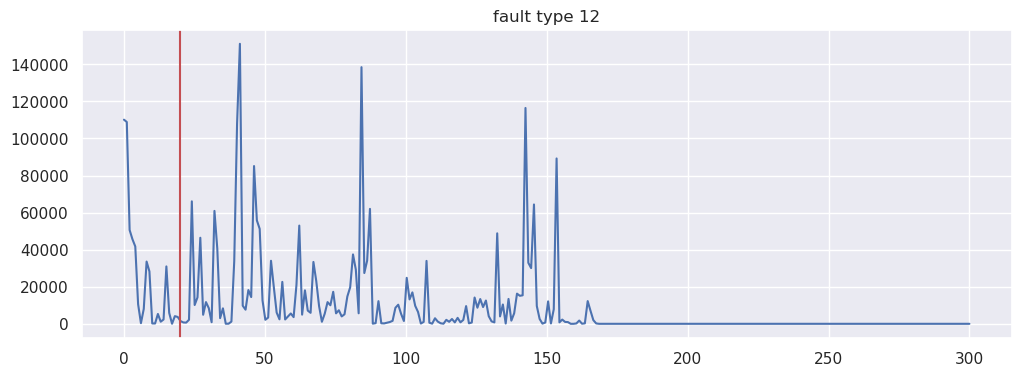

0      1.943026e+05
1      2.118739e+05
2      1.144426e+03
3      5.028263e+03
4      9.128093e+03
           ...     
955    4.694119e-30
956    2.401487e-24
957    1.045813e-24
958    8.685660e-24
959    1.500883e-26
Length: 960, dtype: float64


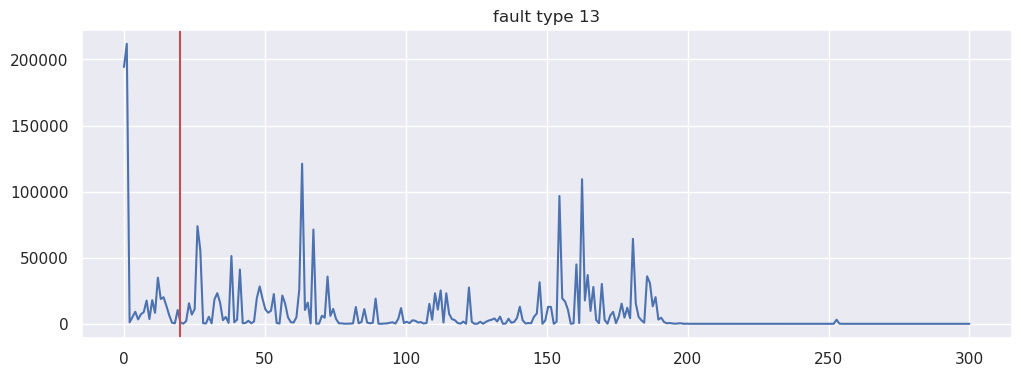

0      1.578124e+05
1      1.324724e+04
2      6.439224e+04
3      2.016113e+04
4      3.986602e+04
           ...     
955    4.119817e-80
956    1.361262e-93
957    6.858736e-77
958    1.004642e-86
959    5.392094e-75
Length: 960, dtype: float64


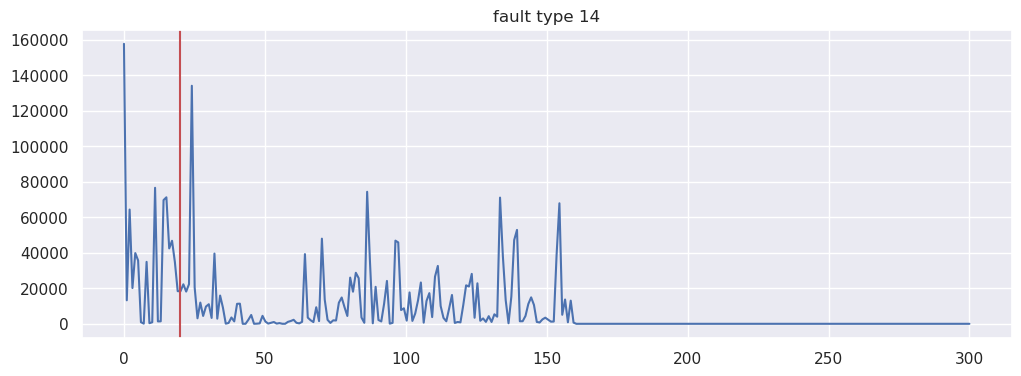

0       38349.248274
1      189505.460806
2        2539.176307
3        7157.251759
4       18079.399442
           ...      
955      2978.111796
956       124.169526
957        27.800421
958      2290.742032
959       811.455794
Length: 960, dtype: float64


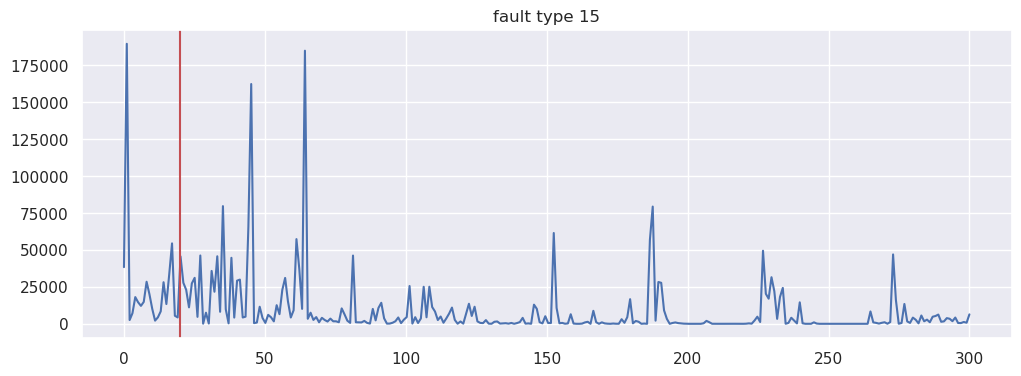

0       14375.113989
1      239268.272652
2       41123.818859
3      136497.208323
4        1482.027616
           ...      
955     30918.108606
956     33765.681446
957     20881.736940
958      2902.777794
959      1093.325999
Length: 960, dtype: float64


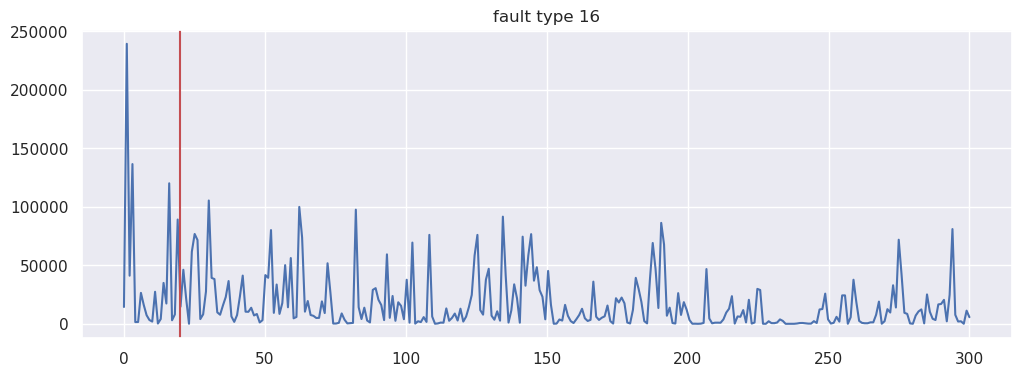

0       2.175097e+05
1       1.671257e+05
2       1.137170e+05
3       7.428729e+03
4       6.736738e+03
           ...      
955     0.000000e+00
956    6.408310e-123
957     2.514525e+02
958     4.698515e-01
959     2.672788e+00
Length: 960, dtype: float64


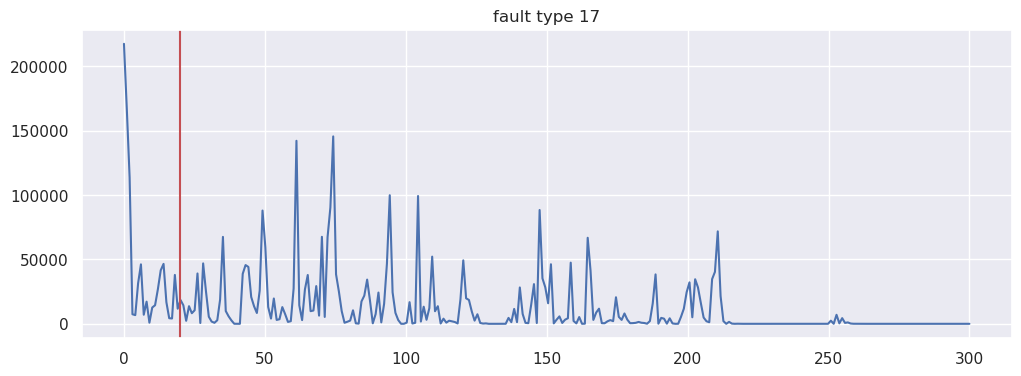

0      131631.573748
1       67150.996522
2       67475.649820
3       56087.372383
4       17314.289782
           ...      
955         0.000000
956         0.000000
957         0.000000
958         0.000000
959         0.000000
Length: 960, dtype: float64


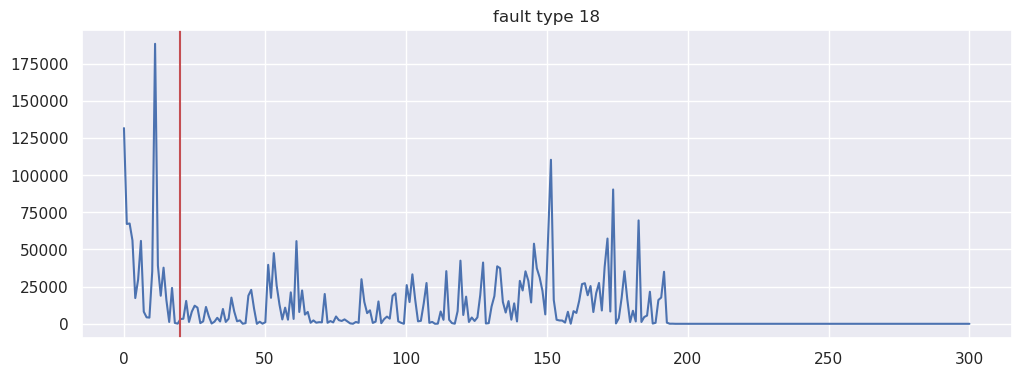

0      112942.558218
1       45838.441007
2       27030.887777
3       40527.040513
4       16474.650736
           ...      
955      5075.068525
956       111.110371
957       238.283047
958       218.625307
959       357.040907
Length: 960, dtype: float64


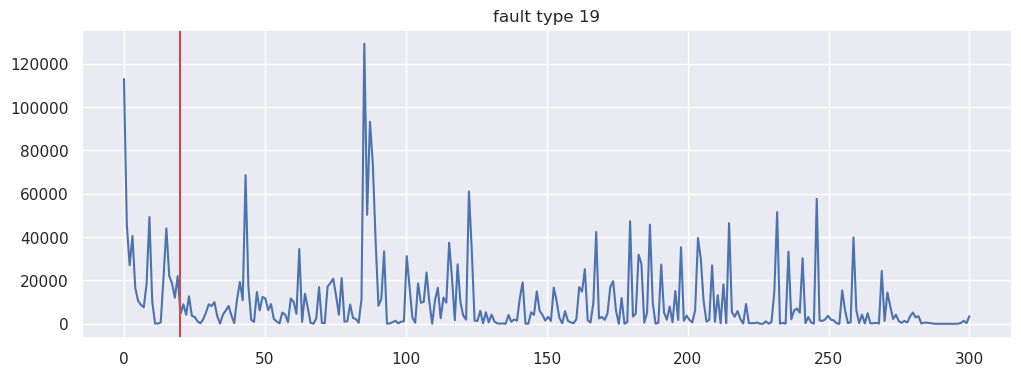

0      149484.223437
1       51627.027383
2       45020.690036
3      152316.342414
4       98249.816014
           ...      
955         0.005498
956         0.018207
957         0.000002
958         0.001373
959         0.001497
Length: 960, dtype: float64


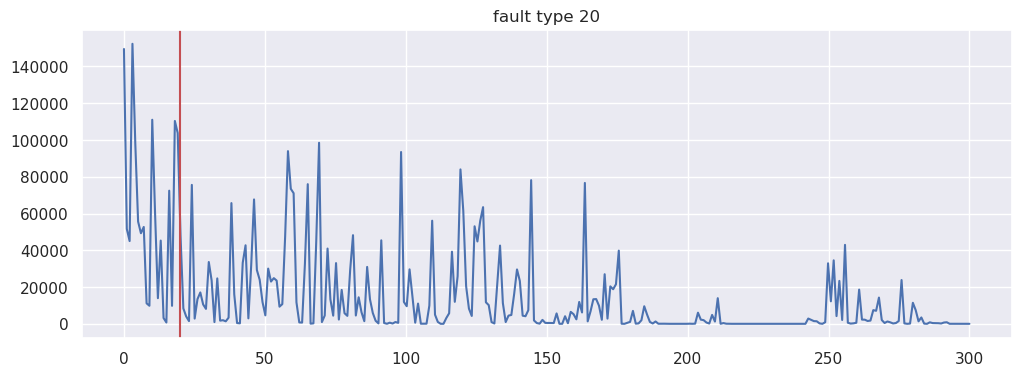

In [34]:
for fault in range(21):
    plt.figure(figsize=(12,4))
    if fault==0:
        scaled = pd.DataFrame(scaler.transform(train_df[(train_df.faultNumber == fault) & (train_df.simulationRun == 401)].loc[:, feature_cols]))
        plt.title('no faults')
        # print(f'{scaled}')
    else:
        scaled = pd.DataFrame(scaler.transform(test_df[(test_df.faultNumber == fault) & (test_df.simulationRun == np.random.randint(500))].loc[:, feature_cols]))
        plt.title('fault type {0}'.format(fault))
    
    probs = scaled.apply(lambda x: get_probability(x, model_prob), axis=1)  # axis=1: 행 단위로 계산
    # print(f'{probs}')
    plt.plot(np.linspace(0,300,300), probs[:300])    
    plt.axvline(x=20, color='r', linestyle='-')

    #alert_point = metric_prob(probs, 30, 1e+05)
    #window_points = 10
    #plt.axvline(x=alert_point, color='y', linestyle='--')
    #plt.axvline(x=alert_point-window_points, color='y', linestyle='--')

    plt.show()